In [1]:
# Written by Gengshan Yang
import sys
sys.path[0] = '/home/rzhu/.conda/envs/mayavi/lib/python2.7/site-packages'
sys.path.append('/home/rzhu/Documents/kitti-lidar-utils')
print sys.path
import itertools
import pdb
import pykitti  # install using pip install pykitti
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mayavi import mlab
mlab.init_notebook() # http://docs.enthought.com/mayavi/mayavi/tips.html
mlab.options.offscreen = True
s = mlab.test_plot3d()
s
from imayavi import *
import time
from source.utils import load_tracklets_for_frames, point_inside, in_hull
from source import parseTrackletXML as xmlParser
import argparse
from matplotlib import cm
from cluster_pcs.filters import *
from math import atan2, degrees
#import pcl

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

parser=argparse.ArgumentParser()
parser.add_argument('--fdir',type=str,help='dir of format base/data/drive',default='/data/KITTI/2011_09_26/2011_09_26_drive_0009_sync')
parser.add_argument('--outdir',type=str,help='output dir',default='/data/output')
# args = parser.parse_args()
args = parser.parse_args(['--fdir', '/home/rzhu/Documents/kitti_dataset/raw/2011_09_26/2011_09_26_drive_0005_sync/', '--outdir', './output/'])


# Raw Data directory information
path = args.fdir.rstrip('/')
basedir = path.rsplit('/',2)[0]
date = path.split('/')[-2]
drive = path.split('/')[-1].split('_')[-2]
outdir = '%s/%s_%s' % (args.outdir,date,drive)

dataset = pykitti.raw(basedir, date, drive)
tracklet_rects, tracklet_types, tracklet_ids = load_tracklets_for_frames(len(list(dataset.velo)),\
               '{}/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(basedir,date, date, drive))
dataset_gray = list(dataset.gray)
dataset_rgb = list(dataset.rgb) 

# view point
# v1 = next(iter(itertools.islice(dataset.oxts, 0, None))).T_w_imu.dot([0,0,0,1])
# v2 = next(iter(itertools.islice(dataset.oxts, 1, None))).T_w_imu.dot([0,0,0,1])
# vec = (v1 - v2)[:2]
# deg = degrees(atan2(vec[1],vec[0]))
# config=(deg, 70.545295075710314, 56.913794133592624,[ 0.,   1.,   1.])

# begin drawing
if not os.path.exists(outdir):
    os.makedirs(outdir)
    print('======Made:', outdir)
else:
	print('======Exists:', outdir)

['/home/rzhu/.conda/envs/mayavi/lib/python2.7/site-packages', '/home/rzhu/.conda/envs/mayavi/lib/python27.zip', '/home/rzhu/.conda/envs/mayavi/lib/python2.7', '/home/rzhu/.conda/envs/mayavi/lib/python2.7/plat-linux2', '/home/rzhu/.conda/envs/mayavi/lib/python2.7/lib-tk', '/home/rzhu/.conda/envs/mayavi/lib/python2.7/lib-old', '/home/rzhu/.conda/envs/mayavi/lib/python2.7/lib-dynload', '/home/rzhu/.conda/envs/mayavi/lib/python2.7/site-packages', '/home/rzhu/.conda/envs/mayavi/lib/python2.7/site-packages/mayavi-4.5.1.dev0-py2.7-linux-x86_64.egg', '/home/rzhu/.conda/envs/mayavi/lib/python2.7/site-packages/IPython/extensions', '/home/rzhu/.ipython', '/home/rzhu/Documents/kitti-lidar-utils']
Notebook initialized with x3d backend.


('Parsing tracklet file', '/home/rzhu/Documents/kitti_dataset/raw/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml')
('File contains', 15, 'tracklets')
('Loaded', 15, 'tracklets.')
('======Exists:', './output//2011_09_26_0005')


In [17]:
### From Rui
np.set_printoptions(precision=4, suppress=True)
# print len(dataset_rgb), len(list(dataset.velo))
# print dataset_rgb[0]
# print dataset.calib

cam=2
cam2cam = {}
# R_cam2rect = dataset.calib.R_rect_00
# print dataset.calib.R_rect_20, dataset.calib.R_rect_00

P_rect = dataset.calib.P_rect_20

# velo2cam = dataset.calib.T_cam0_velo_unrect
# print velo2cam
velo2cam = dataset.calib.T_cam2_velo
# print velo2cam

from depth_evaluation_utils import *
# test_files = read_text_lines('/home/rzhu/Documents/SfMLearner/data/kitti/test_files_eigen.txt')
# gt_files, gt_calib, im_sizes, im_files, cams = \
#     read_file_data(test_files, '/home/rzhu/Documents/kitti_dataset/raw/')
# num_test = len(im_files)

# calib_dir = '/home/rzhu/Documents/kitti_dataset/raw/2011_09_26/'
# cam2cam = read_calib_file(calib_dir + 'calib_cam_to_cam.txt')
# velo2cam = read_calib_file(calib_dir + 'calib_velo_to_cam.txt')
# velo2cam = np.hstack((velo2cam['R'].reshape(3,3), velo2cam['T'][..., np.newaxis]))
# velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))

# print velo2cam # WHERE is this in pykitti?

# # compute [projection matrix] velodyne->image plane
# R_cam2rect = np.eye(4)
# R_cam2rect[:3,:3] = cam2cam['R_rect_00'].reshape(3,3)
# P_rect = cam2cam['P_rect_0'+str(cam)].reshape(3,4)
P_velo2im = np.dot(P_rect, velo2cam) # 4*3
print P_velo2im

# print P_rect
# print velo2cam

### From SfMLearner
calib_dir = '/home/rzhu/Documents/kitti_dataset/raw/%s/'%date
cam2cam = read_calib_file(calib_dir + 'calib_cam_to_cam.txt')
velo2cam = read_calib_file(calib_dir + 'calib_velo_to_cam.txt')
velo2cam = np.hstack((velo2cam['R'].reshape(3,3), velo2cam['T'][..., np.newaxis])) # == dataset.calib.T_cam0_velo_unrect
velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))
# compute [projection matrix] velodyne->image plane
R_cam2rect = np.eye(4)
R_cam2rect[:3,:3] = cam2cam['R_rect_00'].reshape(3,3)
P_rect = cam2cam['P_rect_0'+str(cam)].reshape(3,4)
P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam) # 4*3
print P_velo2im

[[ 609.6954 -721.4216   -1.2513  -78.1845]
 [ 180.3842    7.6448 -719.6515 -101.0167]
 [   0.9999    0.0001    0.0105   -0.2694]]
[[ 609.6954 -721.4216   -1.2513 -123.0418]
 [ 180.3842    7.6448 -719.6515 -101.0167]
 [   0.9999    0.0001    0.0105   -0.2694]]


In [14]:
### Read gnd calib
# Image 0 from the training set has index 7282 and maps to date 2011_09_28, drive 106 and frame 48. Drives and frames are 0-based.
image_id = 0

file = open("/home/rzhu/Documents/kitti_dataset/devkit_object/mapping/train_rand.txt","r")
for line in file:
    fields = line.split(",")
file.close()    
image_to_index = [int(field.replace('\n', '')) for field in fields]
print image_to_index[image_id], len(image_to_index), max(image_to_index) # index is 1-based

file = open("/home/rzhu/Documents/kitti_dataset/devkit_object/mapping/train_mapping.txt","r")
index_to_details = []
for line in file:
    fields = line.split(" ")
    index_to_details.append([field.replace('\n', '') for field in fields])
file.close()
print index_to_details[int(image_to_index[image_id])-1]

# for date 2011_09_26, drive 9 and frame 1:
index=11
# image_idx = 
# print image_to_index
image_id = image_to_index.index(index)
print image_id, index_to_details[int(image_to_index[image_id])-1]

# In matlab: readCalibration(calib_dir,5572,2)
#
#ans =
#
#  721.5377         0  609.5593   44.8573
#         0  721.5377  172.8540    0.2164
#         0         0    1.0000    0.0027

print dataset.oxts[0]
print dataset.calib

7282 7481 7481
['2011_09_28', '2011_09_28_drive_0106_sync', '0000000048']
5572 ['2011_09_26', '2011_09_26_drive_0009_sync', '0000000001']


(3, 4) (2256, 4)


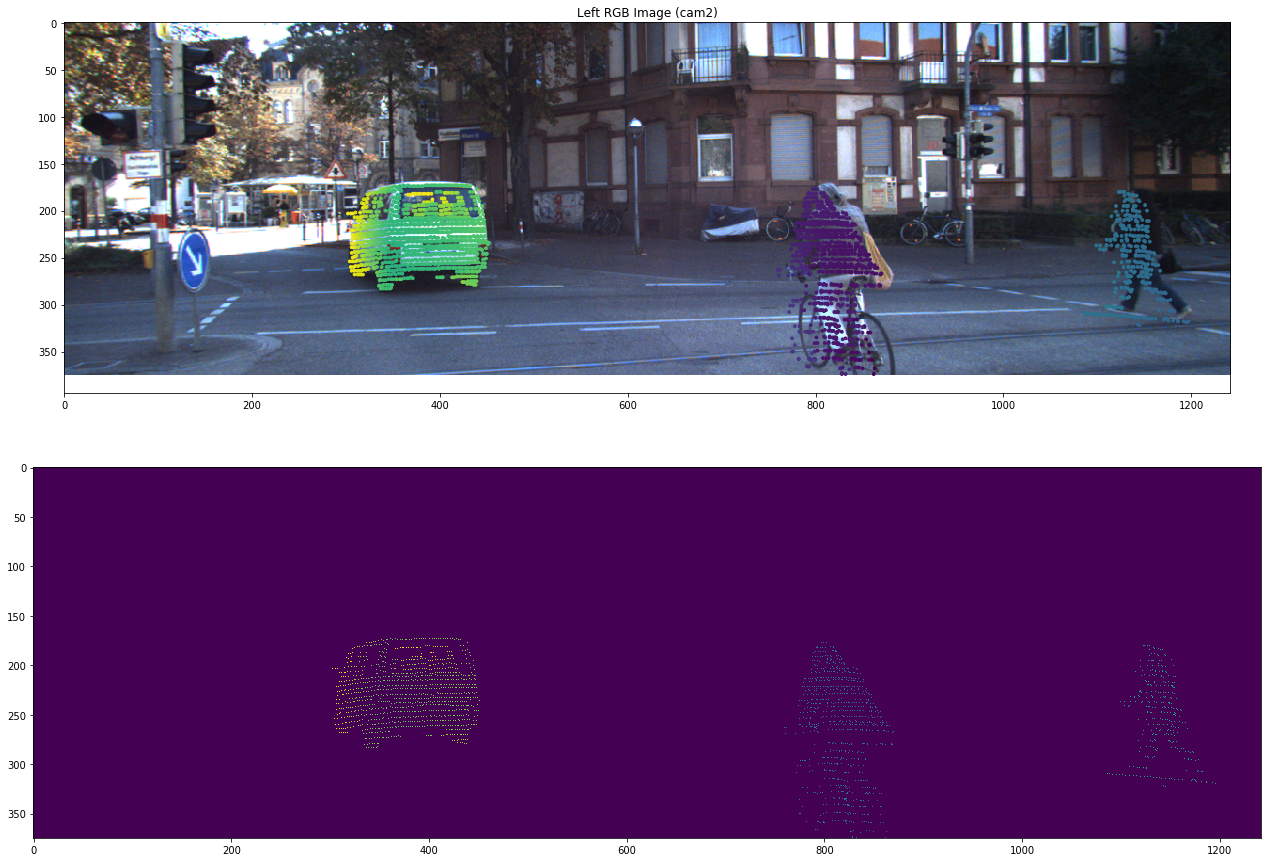

('./output/2011_09_26_0005/test_000.png', (900, 1200, 3))


In [16]:
cen=np.zeros((0,4))
#prev_velo = None
#reg = pcl.IterativeClosestPointNonLinear()
fig_scale = 300
fig_ratio = [4, 3]
# plt.show()
fig = mlab.figure(bgcolor=(0, 0, 0), size=(fig_ratio[0]*fig_scale, fig_ratio[1]*fig_scale))
for i,velo in enumerate(dataset.velo):
    mlab.clf()
    cen = np.vstack((cen, [0,0,0,1]))
    mlab.points3d(cen[:,0],cen[:,1],cen[:,2],color=(1,0,0),scale_factor=0.5)
    
    # Ground only
#     velo = filter_ground(velo,cen,th=1000)
    # Front only
    velo = velo[velo[:, 0] >= 0, :]

    # draw annotated objects
    filled_idx = np.zeros((velo.shape[0],),dtype=bool)
    for j,box in enumerate(tracklet_rects[i]):
        draw_class.draw_box(box, tracklet_ids[i][j])
        idx = in_hull(velo[:,:3],box[:3,:].T)
        draw_class.draw_cluster(velo[idx,:], tracklet_ids[i][j])
        filled_idx |= idx
    
    # print other points
    draw_class.draw_cluster(velo[~filled_idx,:])

    mlab.view(azimuth=180, elevation=70, distance=50, focalpoint=[20., 0., 0.]) # tracking-view
    # mlab.view(azimuth=180, elevation=0, distance=70, roll=90, focalpoint=[0., 0., 0.]) # over-view

    plt_img = imayavi_return_inline(fig=fig)
    
    
#     ## Plot 1: 3D
#     plt_fig = plt.figure(1, figsize=(fig_ratio[0], fig_ratio[1]), dpi=fig_scale)
#     ax_fig = plt_fig.add_axes([0, 0, 1, 1])
#     ax_fig.axis('off')
#     plt.imshow(plt_img)
# #     plt_fig.canvas.draw()
#     plt.show()
    
#     ## Plot 2: RGB
#     f, ax = plt.subplots(2, 2, figsize=(24, 8))
#     ax[0, 0].imshow(dataset_gray[i][0], cmap='gray')
#     ax[0, 0].set_title('Left Gray Image (cam0)')
#     ax[0, 1].imshow(dataset_gray[i][1], cmap='gray')
#     ax[0, 1].set_title('Right Gray Image (cam1)')
#     ax[1, 0].imshow(dataset_rgb[i][0])
#     ax[1, 0].set_title('Left RGB Image (cam2)')
#     ax[1, 1].imshow(dataset_rgb[i][1])
#     ax[1, 1].set_title('Right RGB Image (cam3)')
#     plt.show()
# #     mlab.savefig('./output/%s_%s/test_%03d.png'%(date,drive,i))M

    ## Plot 3: Projection
    vel_depth = True
    im_shape = [375, 1242]
    # project the points to the camera
    # Filter points inside bbox
    velo = velo[filled_idx,:]
    velo_pts_im = np.dot(P_velo2im, velo.T).T # [*, 3]
    print P_velo2im.shape, velo.shape
    velo_pts_im[:, :2] = velo_pts_im[:,:2] / velo_pts_im[:,2][..., np.newaxis]

    if vel_depth: # Use velo first dimmension as depth
        velo_pts_im[:, 2] = velo[:, 0]

    # check if in bounds
    # use minus 1 to get the exact same value as KITTI matlab code
    velo_pts_im[:, 0] = np.round(velo_pts_im[:,0]) - 1
    velo_pts_im[:, 1] = np.round(velo_pts_im[:,1]) - 1
    val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
    val_inds = val_inds & (velo_pts_im[:,0] < im_shape[1]) & (velo_pts_im[:,1] < im_shape[0])
    velo_pts_im = velo_pts_im[val_inds, :]

    # project to image
    depth = np.zeros((im_shape))
    depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]

    # find the duplicate points and choose the closest depth
    inds = sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
    dupe_inds = [item for item, count in Counter(inds).iteritems() if count > 1]
    for dd in dupe_inds:
        pts = np.where(inds==dd)[0]
        x_loc = int(velo_pts_im[pts[0], 0])
        y_loc = int(velo_pts_im[pts[0], 1])
        depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
    depth[depth<0] = np.nan
    # print(depth.shape) # (376, 1241)
    f, ax = plt.subplots(2, 1, figsize=(45, 15))
    ax[0].imshow(dataset_rgb[i][0])
    ax[0].scatter(velo_pts_im[:, 0].astype(np.int), velo_pts_im[:, 1].astype(np.int), s=8, c=velo_pts_im[:, 2])
    ax[0].set_title('Left RGB Image (cam2)')
    ax[1].imshow(depth)
#     ax[0, 1].imshow(dataset_rgb[i][1])
#     ax[0, 1].set_title('Right RGB Image (cam3)')
    plt.show()
    print('./output/%s_%s/test_%03d.png'%(date,drive,i), plt_img.shape)
    break